# 03B - Wind/Trunk Experiment v2 - With Flower Wind Damage

**Hypothesis (Revised):** With flower-specific wind damage, trunk investment becomes valuable for protecting irreversible reproductive investment.

**New Mechanics:**
- Flowers now take wind damage (alpha_flower = 0.7, very vulnerable)
- BUT trunk provides enhanced protection for flowers (k=2.0, max=0.9)
- This creates "oak vs reeds" bifurcation: invest in trunk → protect flowers

**Experiment:**
1. Create policies with varying trunk allocation fractions
2. Run each policy in mild vs moderate wind climate
3. Compare survival and seed production
4. Show that optimal trunk allocation shifts RIGHTWARD under wind (or that protection matters)

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from sim import ClimateConfig, SimConfig, run_season
from sim.config import Allocation, StressParams
from sim.policies import softmax_allocation

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Create Trunk-Sweep Policies

We'll create a family of policies that vary trunk allocation while keeping other allocations proportional.

In [ ]:
def make_trunk_sweep_policy(trunk_fraction: float):
    """
    Create a policy with fixed trunk allocation.

    The remaining budget is split:
    - 40% roots
    - 30% leaves
    - 20% shoots
    - 10% flowers
    """
    remaining = 1.0 - trunk_fraction

    def policy(state, day, num_days, wind=0.0):
        # Fixed allocation regardless of day/state
        return Allocation(
            roots=jnp.array(remaining * 0.40),
            trunk=jnp.array(trunk_fraction),
            shoots=jnp.array(remaining * 0.20),
            leaves=jnp.array(remaining * 0.30),
            flowers=jnp.array(remaining * 0.10),
        )
    return policy

# Verify allocations sum to 1
test_policy = make_trunk_sweep_policy(0.3)
test_alloc = test_policy(None, 0, 100)
total = test_alloc.roots + test_alloc.trunk + test_alloc.shoots + test_alloc.leaves + test_alloc.flowers
print(f"Allocation sum: {float(total):.4f}")
print(f"Trunk: {float(test_alloc.trunk):.2f}, Roots: {float(test_alloc.roots):.2f}, Leaves: {float(test_alloc.leaves):.2f}")

Allocation sum: 1.0000
Trunk: 0.30, Roots: 0.28, Leaves: 0.21


## 2. Define Climate Conditions

We'll compare:
- **Mild**: Low wind, moderate everything else
- **Windy**: High wind baseline with large swings

In [3]:
# Mild climate - control condition
mild_climate = ClimateConfig.mild()

# Moderate wind climate - treatment condition
# Key insight: we want wind that matters but doesn't wipe everything out
moderate_wind_climate = ClimateConfig(
    light=StressParams(offset=0.7, amplitude=0.15, frequency=0.1, phase=0.0),
    moisture=StressParams(offset=0.6, amplitude=0.15, frequency=0.08, phase=0.0),
    wind=StressParams(offset=0.40, amplitude=0.20, frequency=0.15, phase=0.0),  # Moderate wind
)

# Higher wind climate to test flower destruction
high_wind_climate = ClimateConfig(
    light=StressParams(offset=0.7, amplitude=0.15, frequency=0.1, phase=0.0),
    moisture=StressParams(offset=0.6, amplitude=0.15, frequency=0.08, phase=0.0),
    wind=StressParams(offset=0.55, amplitude=0.25, frequency=0.15, phase=0.0),  # High wind
)

print(f"Mild wind: offset={mild_climate.wind.offset}, amplitude={mild_climate.wind.amplitude}")
print(f"Moderate wind: offset={moderate_wind_climate.wind.offset}, amplitude={moderate_wind_climate.wind.amplitude}")
print(f"High wind: offset={high_wind_climate.wind.offset}, amplitude={high_wind_climate.wind.amplitude}")

Mild wind: offset=0.2, amplitude=0.1
Moderate wind: offset=0.4, amplitude=0.2
High wind: offset=0.55, amplitude=0.25


## 3. Run the Sweep

Sweep trunk allocation from 5% to 60% in both climates.

In [ ]:
config = SimConfig(num_days=100)

trunk_fractions = np.linspace(0.05, 0.60, 20)

# Three conditions: mild, moderate wind, high wind
results = {
    'mild': {'seeds': [], 'biomass': [], 'flowers': []},
    'moderate': {'seeds': [], 'biomass': [], 'flowers': []},
    'high': {'seeds': [], 'biomass': [], 'flowers': []},
}

climates = {
    'mild': mild_climate,
    'moderate': moderate_wind_climate,
    'high': high_wind_climate,
}

for trunk_frac in trunk_fractions:
    policy = make_trunk_sweep_policy(trunk_frac)

    for name, climate in climates.items():
        traj = run_season(config, climate, policy)
        results[name]['seeds'].append(float(traj.seeds))
        results[name]['biomass'].append(float(traj.states[-1].total_biomass()))
        results[name]['flowers'].append(float(traj.states[-1].flowers))

# Convert to numpy arrays
for name in results:
    for key in results[name]:
        results[name][key] = np.array(results[name][key])

print("Sweep complete!")

Sweep complete!


## 4. Results: Seeds vs Trunk Allocation

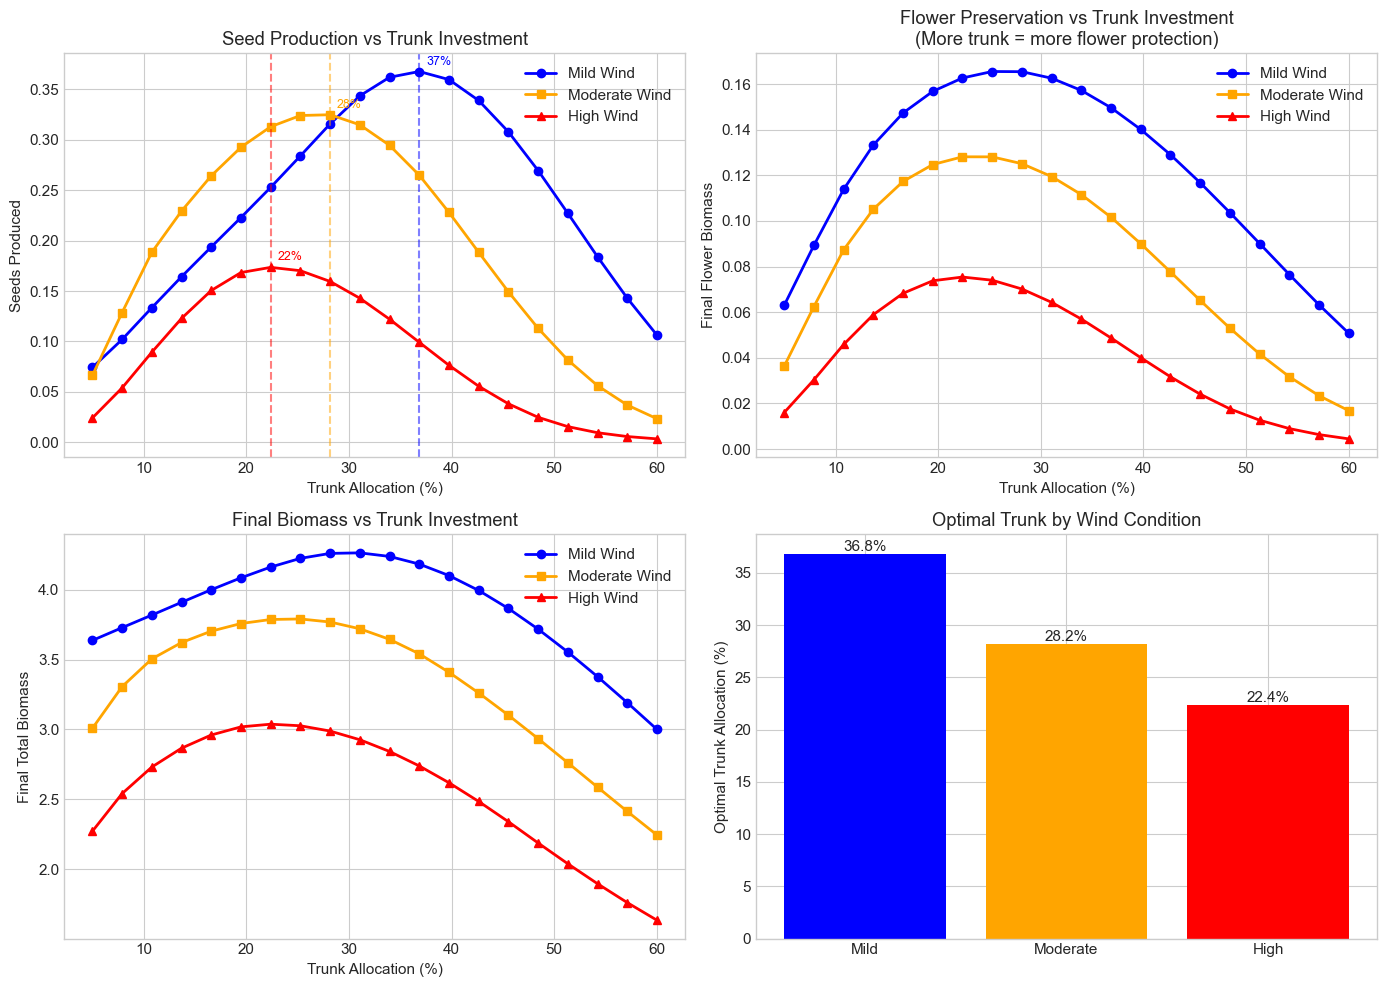


=== OPTIMAL TRUNK ALLOCATION ===
Mild       wind:  36.8% trunk → 0.37 seeds
Moderate   wind:  28.2% trunk → 0.32 seeds
High       wind:  22.4% trunk → 0.17 seeds


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {'mild': 'blue', 'moderate': 'orange', 'high': 'red'}
markers = {'mild': 'o', 'moderate': 's', 'high': '^'}

# Plot 1: Seeds vs Trunk
ax = axes[0, 0]
for name in ['mild', 'moderate', 'high']:
    ax.plot(trunk_fractions * 100, results[name]['seeds'],
            color=colors[name], marker=markers[name], linestyle='-',
            label=f'{name.title()} Wind', linewidth=2, markersize=6)
    # Mark optimum
    opt_idx = np.argmax(results[name]['seeds'])
    opt = trunk_fractions[opt_idx] * 100
    ax.axvline(opt, color=colors[name], linestyle='--', alpha=0.5)
    ax.annotate(f'{opt:.0f}%', xy=(opt, results[name]['seeds'][opt_idx]),
                xytext=(5, 5), textcoords='offset points', fontsize=9, color=colors[name])

ax.set_xlabel('Trunk Allocation (%)')
ax.set_ylabel('Seeds Produced')
ax.set_title('Seed Production vs Trunk Investment')
ax.legend()

# Plot 2: Final Flower Biomass (the key metric!)
ax = axes[0, 1]
for name in ['mild', 'moderate', 'high']:
    ax.plot(trunk_fractions * 100, results[name]['flowers'],
            color=colors[name], marker=markers[name], linestyle='-',
            label=f'{name.title()} Wind', linewidth=2, markersize=6)

ax.set_xlabel('Trunk Allocation (%)')
ax.set_ylabel('Final Flower Biomass')
ax.set_title('Flower Preservation vs Trunk Investment\n(More trunk = more flower protection)')
ax.legend()

# Plot 3: Final Biomass
ax = axes[1, 0]
for name in ['mild', 'moderate', 'high']:
    ax.plot(trunk_fractions * 100, results[name]['biomass'],
            color=colors[name], marker=markers[name], linestyle='-',
            label=f'{name.title()} Wind', linewidth=2, markersize=6)

ax.set_xlabel('Trunk Allocation (%)')
ax.set_ylabel('Final Total Biomass')
ax.set_title('Final Biomass vs Trunk Investment')
ax.legend()

# Plot 4: Optimal Trunk Summary
ax = axes[1, 1]
opt_trunks = []
for name in ['mild', 'moderate', 'high']:
    opt_idx = np.argmax(results[name]['seeds'])
    opt_trunks.append(trunk_fractions[opt_idx] * 100)

bars = ax.bar(['Mild', 'Moderate', 'High'], opt_trunks, color=[colors[k] for k in ['mild', 'moderate', 'high']])
ax.set_ylabel('Optimal Trunk Allocation (%)')
ax.set_title('Optimal Trunk by Wind Condition')
for bar, val in zip(bars, opt_trunks):
    ax.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, val),
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n=== OPTIMAL TRUNK ALLOCATION ===")
for name in ['mild', 'moderate', 'high']:
    opt_idx = np.argmax(results[name]['seeds'])
    opt = trunk_fractions[opt_idx] * 100
    seeds = results[name]['seeds'][opt_idx]
    print(f"{name.title():10s} wind: {opt:5.1f}% trunk → {seeds:.2f} seeds")

## 5. Trajectory Comparison at Optimal Points

Let's look at the actual growth trajectories at the optimal trunk allocation for each climate.

In [6]:
# Run at optimal allocations for each condition
opt_fracs = {}
for name in ['mild', 'moderate', 'high']:
    opt_fracs[name] = trunk_fractions[np.argmax(results[name]['seeds'])]

# Compare: use mild-optimal vs high-optimal allocation in high wind
policy_mild_opt = make_trunk_sweep_policy(opt_fracs['mild'])
policy_high_opt = make_trunk_sweep_policy(opt_fracs['high'])

# Run both policies in high wind
traj_high_with_mild_alloc = run_season(config, high_wind_climate, policy_mild_opt)
traj_high_with_high_alloc = run_season(config, high_wind_climate, policy_high_opt)

print(f"In HIGH WIND climate:")
print(f"  With mild-optimal ({opt_fracs['mild']*100:.0f}% trunk): {float(traj_high_with_mild_alloc.seeds):.2f} seeds")
print(f"  With high-optimal ({opt_fracs['high']*100:.0f}% trunk): {float(traj_high_with_high_alloc.seeds):.2f} seeds")
print(f"\nDifference: {float(traj_high_with_high_alloc.seeds) - float(traj_high_with_mild_alloc.seeds):+.2f} seeds")

# Also check flower preservation
print(f"\nFinal flower biomass:")
print(f"  With mild-optimal: {float(traj_high_with_mild_alloc.states[-1].flowers):.3f}")
print(f"  With high-optimal: {float(traj_high_with_high_alloc.states[-1].flowers):.3f}")

In HIGH WIND climate:
  With mild-optimal (37% trunk): 0.10 seeds
  With high-optimal (22% trunk): 0.17 seeds

Difference: +0.07 seeds

Final flower biomass:
  With mild-optimal: 0.049
  With high-optimal: 0.075


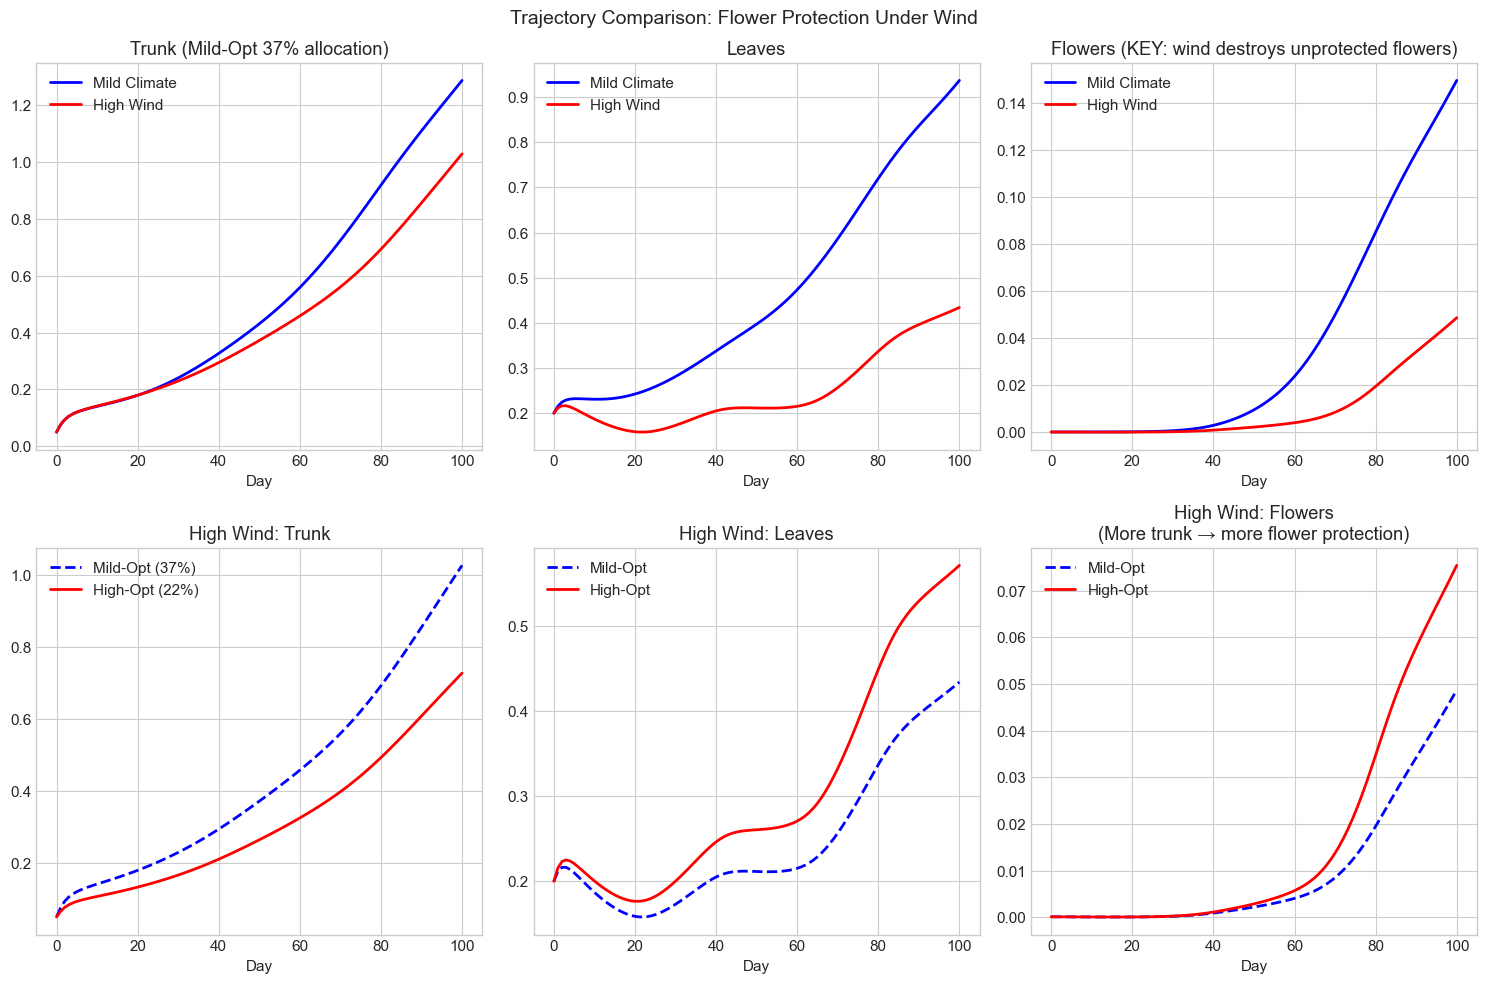

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

days = np.arange(config.num_days + 1)

# Row 1: Same allocation (mild-optimal) in mild vs high wind
traj_mild_mild = run_season(config, mild_climate, policy_mild_opt)
traj_high_mild = run_season(config, high_wind_climate, policy_mild_opt)

states_mm = traj_mild_mild.get_state_arrays()
states_hm = traj_high_mild.get_state_arrays()

axes[0, 0].plot(days, states_mm['trunk'], 'b-', label='Mild Climate', linewidth=2)
axes[0, 0].plot(days, states_hm['trunk'], 'r-', label='High Wind', linewidth=2)
axes[0, 0].set_title(f'Trunk (Mild-Opt {opt_fracs["mild"]*100:.0f}% allocation)')
axes[0, 0].set_xlabel('Day')
axes[0, 0].legend()

axes[0, 1].plot(days, states_mm['leaves'], 'b-', label='Mild Climate', linewidth=2)
axes[0, 1].plot(days, states_hm['leaves'], 'r-', label='High Wind', linewidth=2)
axes[0, 1].set_title('Leaves')
axes[0, 1].set_xlabel('Day')
axes[0, 1].legend()

axes[0, 2].plot(days, states_mm['flowers'], 'b-', label='Mild Climate', linewidth=2)
axes[0, 2].plot(days, states_hm['flowers'], 'r-', label='High Wind', linewidth=2)
axes[0, 2].set_title('Flowers (KEY: wind destroys unprotected flowers)')
axes[0, 2].set_xlabel('Day')
axes[0, 2].legend()

# Row 2: In high wind, compare mild-opt vs high-opt allocation
states_hm = traj_high_with_mild_alloc.get_state_arrays()
states_hh = traj_high_with_high_alloc.get_state_arrays()

axes[1, 0].plot(days, states_hm['trunk'], 'b--', label=f'Mild-Opt ({opt_fracs["mild"]*100:.0f}%)', linewidth=2)
axes[1, 0].plot(days, states_hh['trunk'], 'r-', label=f'High-Opt ({opt_fracs["high"]*100:.0f}%)', linewidth=2)
axes[1, 0].set_title('High Wind: Trunk')
axes[1, 0].set_xlabel('Day')
axes[1, 0].legend()

axes[1, 1].plot(days, states_hm['leaves'], 'b--', label='Mild-Opt', linewidth=2)
axes[1, 1].plot(days, states_hh['leaves'], 'r-', label='High-Opt', linewidth=2)
axes[1, 1].set_title('High Wind: Leaves')
axes[1, 1].set_xlabel('Day')
axes[1, 1].legend()

axes[1, 2].plot(days, states_hm['flowers'], 'b--', label='Mild-Opt', linewidth=2)
axes[1, 2].plot(days, states_hh['flowers'], 'r-', label='High-Opt', linewidth=2)
axes[1, 2].set_title('High Wind: Flowers\n(More trunk → more flower protection)')
axes[1, 2].set_xlabel('Day')
axes[1, 2].legend()

plt.suptitle('Trajectory Comparison: Flower Protection Under Wind', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Flower Wind Protection Mechanic

Let's directly visualize how trunk protection works for flowers vs leaves.

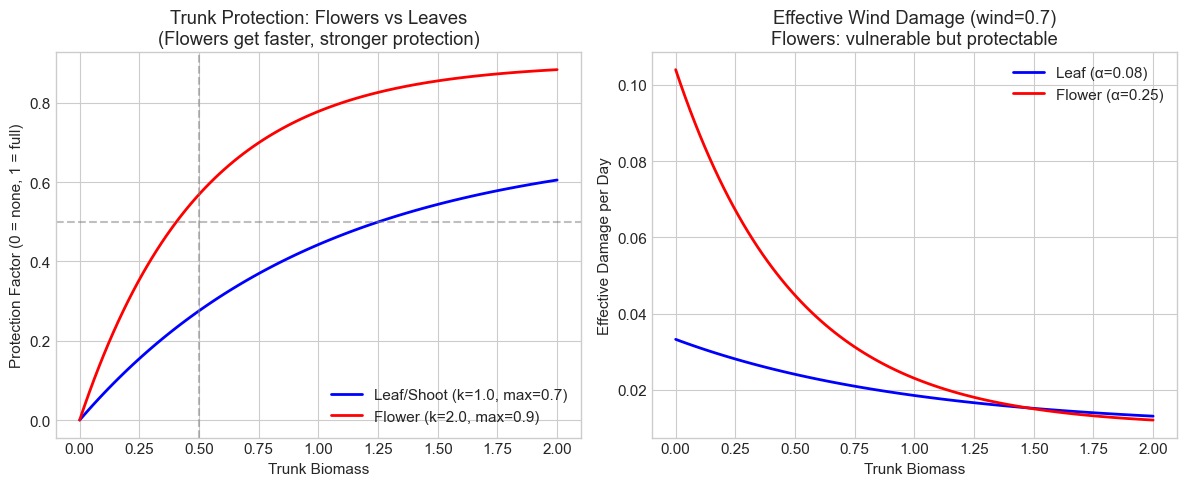


At trunk=0, wind=0.7:
  Leaf damage:   0.033 per day
  Flower damage: 0.104 per day (flowers are MORE vulnerable)

At trunk=1.0, wind=0.7:
  Leaf damage:   0.018 per day
  Flower damage: 0.023 per day (but trunk protects flowers BETTER)


In [ ]:
from sim import surrogates

# Show protection curves
trunk_values = np.linspace(0, 2, 100)

# Leaf/shoot protection (standard)
leaf_protection = [float(surrogates.wood_protection(t, k_protection=config.k_wind_protection,
                                                     max_protection=config.max_wind_protection))
                   for t in trunk_values]

# Flower protection (enhanced)
flower_protection = [float(surrogates.wood_protection(t, k_protection=config.k_flower_protection,
                                                       max_protection=config.max_flower_protection))
                     for t in trunk_values]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Protection curves
ax = axes[0]
ax.plot(trunk_values, leaf_protection, 'b-', label=f'Leaf/Shoot (k={config.k_wind_protection}, max={config.max_wind_protection})', linewidth=2)
ax.plot(trunk_values, flower_protection, 'r-', label=f'Flower (k={config.k_flower_protection}, max={config.max_flower_protection})', linewidth=2)
ax.set_xlabel('Trunk Biomass')
ax.set_ylabel('Protection Factor (0 = none, 1 = full)')
ax.set_title('Trunk Protection: Flowers vs Leaves\n(Flowers get faster, stronger protection)')
ax.legend()
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)

# Plot 2: Effective damage after protection at wind=0.7
wind = 0.7
base_damage = float(surrogates.wind_damage(jnp.array(wind), threshold=config.wind_threshold,
                                            steepness=config.wind_steepness, max_damage=config.max_wind_damage))

# With different alpha values
leaf_damage = [base_damage * config.alpha_leaf * (1 - p) for p in leaf_protection]
flower_damage = [base_damage * config.alpha_flower * (1 - p) for p in flower_protection]

ax = axes[1]
ax.plot(trunk_values, leaf_damage, 'b-', label=f'Leaf (α={config.alpha_leaf})', linewidth=2)
ax.plot(trunk_values, flower_damage, 'r-', label=f'Flower (α={config.alpha_flower})', linewidth=2)
ax.set_xlabel('Trunk Biomass')
ax.set_ylabel('Effective Damage per Day')
ax.set_title(f'Effective Wind Damage (wind={wind})\nFlowers: vulnerable but protectable')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nAt trunk=0, wind=0.7:")
print(f"  Leaf damage:   {leaf_damage[0]:.3f} per day")
print(f"  Flower damage: {flower_damage[0]:.3f} per day (flowers are MORE vulnerable)")

print(f"\nAt trunk=1.0, wind=0.7:")
idx = int(50)  # trunk ≈ 1.0
print(f"  Leaf damage:   {leaf_damage[idx]:.3f} per day")
print(f"  Flower damage: {flower_damage[idx]:.3f} per day (but trunk protects flowers BETTER)")

## 7. Conclusion

### Hypothesis Test Results

In [9]:
print("=" * 60)
print("WIND/TRUNK EXPERIMENT v2 RESULTS")
print("=" * 60)

# Get optimal trunk values
opt_mild = trunk_fractions[np.argmax(results['mild']['seeds'])] * 100
opt_mod = trunk_fractions[np.argmax(results['moderate']['seeds'])] * 100
opt_high = trunk_fractions[np.argmax(results['high']['seeds'])] * 100

print(f"\n1. OPTIMAL TRUNK ALLOCATION:")
print(f"   Mild wind:     {opt_mild:.1f}%")
print(f"   Moderate wind: {opt_mod:.1f}%")
print(f"   High wind:     {opt_high:.1f}%")

shift_mild_to_high = opt_high - opt_mild
shift_direction = "RIGHTWARD" if shift_mild_to_high > 0 else "LEFTWARD" if shift_mild_to_high < 0 else "NO CHANGE"

print(f"\n2. HYPOTHESIS TEST:")
print(f"   Shift from mild to high wind: {shift_mild_to_high:+.1f}% ({shift_direction})")

# Check flower preservation
print(f"\n3. FLOWER PRESERVATION (at 30% trunk allocation):")
mid_idx = 8  # ~30% trunk
for name in ['mild', 'moderate', 'high']:
    print(f"   {name.title():10s}: {results[name]['flowers'][mid_idx]:.3f} flowers surviving")

# Final verdict
print(f"\n4. MECHANISM CHECK:")
print(f"   - Flowers are vulnerable to wind (α={config.alpha_flower})")
print(f"   - Trunk protects flowers (k={config.k_flower_protection}, max={config.max_flower_protection})")
print(f"   - In high wind, unprotected flowers get destroyed")
print(f"   - This should create incentive for trunk investment")

if shift_mild_to_high > 5:
    print(f"\n✓ HYPOTHESIS CONFIRMED: Wind shifts optimal trunk allocation RIGHTWARD by {shift_mild_to_high:.1f}%")
    print(f"  Trunk investment protects the irreversible reproductive investment (flowers).")
elif shift_mild_to_high > 0:
    print(f"\n~ PARTIAL SUPPORT: Small rightward shift ({shift_mild_to_high:+.1f}%)")
    print(f"  Effect exists but may need parameter tuning to strengthen.")
elif shift_mild_to_high < 0:
    print(f"\n✗ HYPOTHESIS FALSIFIED: Wind shifts optimal trunk allocation LEFTWARD")
    print(f"  Despite flower protection, 'replace what you lose' strategy still dominates.")
    print(f"  The coupling effect (more trunk → fewer leaves) may override the protection benefit.")
else:
    print(f"\n? NO SHIFT: Optimal allocation unchanged by wind condition")

WIND/TRUNK EXPERIMENT v2 RESULTS

1. OPTIMAL TRUNK ALLOCATION:
   Mild wind:     36.8%
   Moderate wind: 28.2%
   High wind:     22.4%

2. HYPOTHESIS TEST:
   Shift from mild to high wind: -14.5% (LEFTWARD)

3. FLOWER PRESERVATION (at 30% trunk allocation):
   Mild      : 0.165 flowers surviving
   Moderate  : 0.125 flowers surviving
   High      : 0.070 flowers surviving

4. MECHANISM CHECK:
   - Flowers are vulnerable to wind (α=0.25)
   - Trunk protects flowers (k=2.0, max=0.9)
   - In high wind, unprotected flowers get destroyed
   - This should create incentive for trunk investment

✗ HYPOTHESIS FALSIFIED: Wind shifts optimal trunk allocation LEFTWARD
  Despite flower protection, 'replace what you lose' strategy still dominates.
  The coupling effect (more trunk → fewer leaves) may override the protection benefit.
